In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import os
print(tf.__version__)

2.0.0


In [82]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)   #[60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)   #[10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)  #[60000]
        self.test_label = self.test_label.astype(np.int32)   #[10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.train_data, self.train_label))
        self.train_dataset = self.train_dataset.shuffle(buffer_size=23000)
        self.train_dataset = self.train_dataset.batch(batch_size)
        self.train_dataset = self.train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        self.test_dataset = tf.data.Dataset.from_tensor_slices((self.test_data, self.test_label))
        self.test_dataset = self.test_dataset.shuffle(buffer_size=23000)
        self.test_dataset = self.test_dataset.batch(batch_size)
        self.test_dataset = self.test_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
class Autoencoder_MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
        
        self.dense3 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.dense4 = tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid)
        self.reshape = tf.keras.layers.Reshape((28,28,1))

    def encoder(self, inputs):
        print(inputs.dtype)
        x = self.flatten(inputs)
        x = self.dense1(x)
        out = self.dense2(x)
        return out
    
    def decoder(self, inputs):
        x = self.dense3(inputs)
        x = self.dense4(x)
        out = self.reshape(x)
        return out
        
    def call(self, inputs, training=None):
        x = self.encoder(inputs)
        output = self.decoder(x)
        return output
    
class Autoencoder_CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=[3, 3], strides=(2, 2), padding='same', activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(filters=48, kernel_size=[3, 3], strides=(2, 2), padding='same', activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=(2, 2), padding='valid', activation=tf.nn.relu)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=8, activation=tf.nn.relu)
        
        self.dense2 = tf.keras.layers.Dense(units=576, activation=tf.nn.relu)
        self.reshape = tf.keras.layers.Reshape((3, 3, 64))
        self.conv4 = tf.compat.v1.keras.layers.Conv2DTranspose(filters=64, kernel_size=[3, 3], strides=(2, 2), padding='valid', activation=tf.nn.relu)
        self.conv5 = tf.compat.v1.keras.layers.Conv2DTranspose(filters=48, kernel_size=[3, 3], strides=(2, 2), padding='same', activation=tf.nn.relu)
        self.conv6 = tf.compat.v1.keras.layers.Conv2DTranspose(filters=32, kernel_size=[3, 3], strides=(2, 2), padding='same', activation=tf.nn.relu)
        self.conv7 = tf.compat.v1.keras.layers.Conv2DTranspose(filters=1, kernel_size=[3, 3], strides=(1, 1), padding='same', activation=tf.nn.sigmoid)
        
    def encoder(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        out = self.dense1(x)
        return out
    
    def decoder(self, inputs):
        x = self.dense2(inputs)
        x = self.reshape(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        out = self.conv7(x)
        return out
        
    def call(self, inputs, training=None):
        x = self.encoder(inputs)
        output = self.decoder(x)
        return output

num_epochs = 10
batch_size = 128
learning_rate = 0.001

def train(train_data):
    history = model.fit(
         x = train_data,
         y = train_data,
         epochs=num_epochs,
         verbose=1,
         batch_size = batch_size
         #callbacks=[cp_callback_mc]
    )
    return history
    

    
if __name__ == '__main__':
    checkpoint_path = "training_autoencoder_1/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model = Autoencoder_CNN()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss=tf.keras.losses.binary_crossentropy)
    
    data_loader = MNISTLoader()
    
    cp_callback_mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=0)
    #latest = tf.train.latest_checkpoint(checkpoint_dir)
    #if(latest != None):
        #model.load_weights(latest) 
    

In [83]:
    train(data_loader.train_data)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 43s 714us/sample - loss: 0.2466
Epoch 2/10
60000/60000 [==============================] - 40s 669us/sample - loss: 0.1789
Epoch 3/10
60000/60000 [==============================] - 40s 667us/sample - loss: 0.1648
Epoch 4/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.1591
Epoch 5/10
60000/60000 [==============================] - 44s 741us/sample - loss: 0.1558
Epoch 6/10
60000/60000 [==============================] - 44s 737us/sample - loss: 0.1534
Epoch 7/10
60000/60000 [==============================] - 42s 706us/sample - loss: 0.1516
Epoch 8/10
60000/60000 [==============================] - 39s 657us/sample - loss: 0.1501
Epoch 9/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.1490
Epoch 10/10
60000/60000 [==============================] - 39s 653us/sample - loss: 0.1479


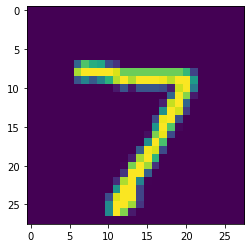

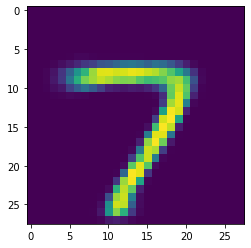

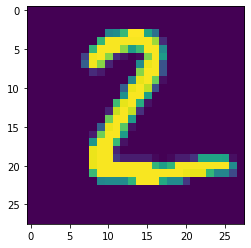

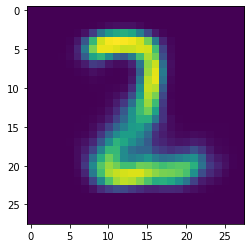

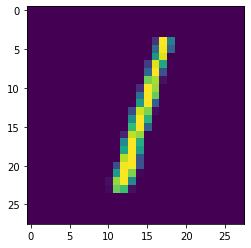

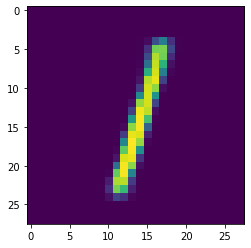

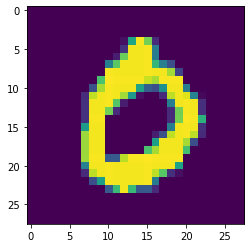

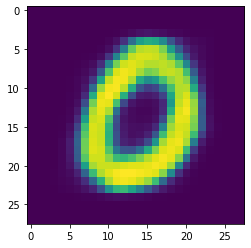

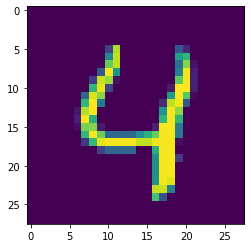

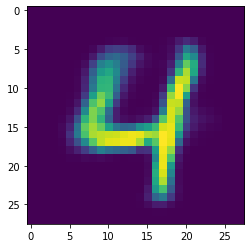

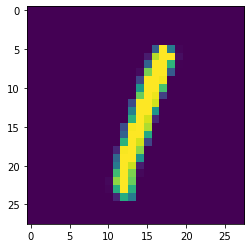

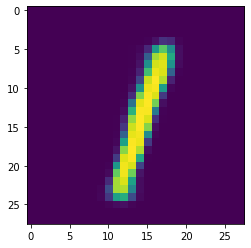

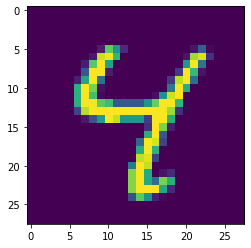

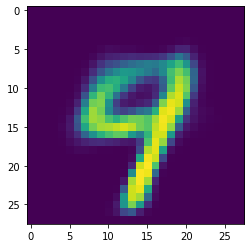

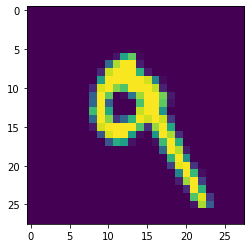

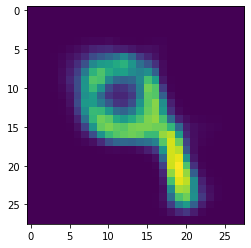

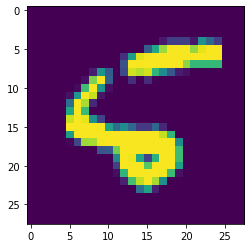

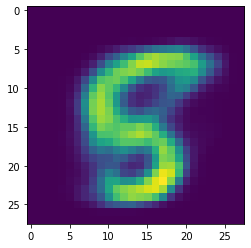

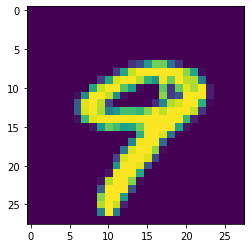

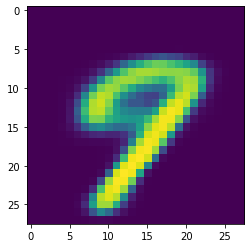

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

images = data_loader.test_data[0:10, :]

y = model.predict(images)

for n in range(10):
    # 将图像数据还原成28*28的分辨率
    image = images[n].reshape(28, 28)
    plt.figure()
    plt.imshow(image)
    plt.show()

    image = y[n].reshape(28, 28)
    plt.figure()
    plt.imshow(image)
    plt.show()